# 模型构建与模型优化
- CNN2d 网络构建
- dropout 缓解过拟和问题（模型优化1）
- batch normalization 数据批标准化(模型优化2)
- model.train and model.eval 训练和预测模式
- 缓解过拟合问题的方法之三
    - 增大训练集
    - dropout：起到平局的作用，减少神经元之间复杂的共适应能力。 该层只有在训练的时候起作用，在预测的时候不起作用。
    - batch normalization：正则化效果，提高模型的泛化能力，加快收敛速度，允许更深的模型，允许更大的学习速率

In [1]:
import os
# copy image
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

import time
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from timm.loss import LabelSmoothingCrossEntropy
from thop import profile, clever_format
%matplotlib inline

from model import basic_cnn, resNet50, InceptionV3
from model import mobileNetV2, mobileNetV3, mobileNetV1
from metrics.metrics_v1 import metric_log

/root/miniconda3/envs/py12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- torchvision.datasets.ImageFolder
- 从分类文件夹中创建dataset
- 所以要创建文件夹，并把各种图片放进去

In [2]:
# specises = ['cloudy', 'rain', 'shine', 'sunrise']
specises = ['aphids', 'armyworm', 'beetle', 'bollworm', "grasshopper", "mites", "mosquito", "sawfly", "stem_borer"]

epoches = 100
BATCHSZ = 16

# model_name = "basicCnnNet1"
# model_name = "basicCnnNet2"
# model_name = 'mobileNetV2'
# model_name = 'mobileNetV3'
model_name = 'mobilenetv3_large'
# model_name = 'mobilenetv3_small'
# model_name = 'mobileNetV1'
# model_name = 'resNet50'
# model_name = 'InceptionV3'
path_head = '/home/leo/Classification/04CNN'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
result_dir = os.path.join(path_head, 'results', \
    datetime.now().strftime("%m%d-%H%M%S-" + model_name))

# create a new file
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
print(result_dir)

/home/leo/Classification/04CNN/results/0823-105305-mobilenetv3_large


In [4]:
# # 这个路径用于储存从原始数据中划分的各个类别的文件夹，每一个类别用一个文件夹存放
# base_dir = '/home/leo/SMD/4weather'
# train_dir = os.path.join(base_dir, 'train')
# test_dir = os.path.join(base_dir, 'test')

# # 判断不是一个文件夹
# if not os.path.isdir(base_dir):
#     os.mkdir(base_dir)
#     os.mkdir(train_dir)
#     os.mkdir(test_dir)
#     # 继续创建各个类别的文件夹
#     for train_or_test in ['train', 'test']:
#         for spec in specises:
#             os.mkdir(os.path.join(base_dir, train_or_test, spec))

In [5]:
# # 文件夹已经存在，放入数据
# image_dir = '/home/leo/SMD/dataset2'
# # enumerate 对应 i, 代表序号
# for i, img in enumerate(os.listdir(image_dir)):
#     for spec in specises:
#         if spec in img:
#             s = os.path.join(image_dir, img)    # source dir
#             # 这里是把 1/5 的数据作为测试集，4/5作为训练集
#             if i % 5 == 0:
#                 # 文件明的拼接
#                 d = os.path.join(base_dir, 'test', spec, img)  # object dir
#             else:
#                 d = os.path.join(base_dir, 'train', spec, img)  # object dir
#             shutil.copy(s, d)

In [6]:
base_dir = "/home/leo/SMD/BAUInsectv2Pest"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

for train_or_test in ['train', 'test']:
    for spec in specises:
        print(train_or_test, spec, len(os.listdir(os.path.join(base_dir, train_or_test, spec))))

train aphids 266
train armyworm 223
train beetle 291
train bollworm 245
train grasshopper 277
train mites 254
train mosquito 295
train sawfly 200
train stem_borer 181
test aphids 44
test armyworm 43
test beetle 50
test bollworm 36
test grasshopper 46
test mites 42
test mosquito 50
test sawfly 37
test stem_borer 36


In [7]:
transform = transforms.Compose([
    # transforms.Resize((156, 156)),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),   # 三个作用，归一化，channel first， tensor
    # RGB 三个维度
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # 这里的均值方差是猜的，知道的情况可以用正确的
])

In [8]:
# train
train_ds = torchvision.datasets.ImageFolder(
                                train_dir, transform=transform)
test_ds = torchvision.datasets.ImageFolder(
                                test_dir, transform=transform)

In [9]:
# 查看类别 
# 查看编号 
print(train_ds.classes, train_ds.class_to_idx)

# 长度
print(len(train_ds), len(test_ds))

# 返回可遍历的(键, 值) 元组数组
print(train_ds.class_to_idx.keys())
# train_ds.class_to_idx

['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer'] {'aphids': 0, 'armyworm': 1, 'beetle': 2, 'bollworm': 3, 'grasshopper': 4, 'mites': 5, 'mosquito': 6, 'sawfly': 7, 'stem_borer': 8}
2232 384
dict_keys(['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer'])


In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCHSZ, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCHSZ)

In [11]:
# # 拿出来一个批次的数据
imgs, labels = next(iter(train_dl))

# # 因为已经用torch的dataset，所以需要改变维度顺序
# # permute 交换channel的顺序，的应用对象是 torch的tensor
# print(imgs[0].shape)
# img = (imgs[0].permute(1, 2, 0).numpy() + 1) / 2
# print(img.shape, img.max(), type(img))

# print("labels", labels)

# # plt.figure(figsize=(12, 8))
# plt.title(labels[0].numpy())
# plt.imshow(img)

In [12]:
# 交换键和值的位置,用于获取值写 title
# 可能这种写法比较简单吧，我没有试验直接获得字符串标签的写法
id_to_class = dict((v, k) for k, v in train_ds.class_to_idx.items())
id_to_class

{0: 'aphids',
 1: 'armyworm',
 2: 'beetle',
 3: 'bollworm',
 4: 'grasshopper',
 5: 'mites',
 6: 'mosquito',
 7: 'sawfly',
 8: 'stem_borer'}

In [13]:
# plt.figure(figsize=(12, 8))
# for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
#     img = (img.permute(1, 2, 0).numpy() + 1) / 2
#     plt.subplot(2, 3, i+1)
#     plt.title(id_to_class.get(label.item()))
#     plt.imshow(img)

# Model

In [14]:
if model_name == "basicCnnNet1":
    model = basic_cnn.Net1(classes=torch.max(labels).item()+1).to(device)
elif model_name == "basicCnnNet2":
    model = basic_cnn.Net2(classes=torch.max(labels).item()+1).to(device)
elif model_name =="mobileNetV2":
    model = mobileNetV2.mobilenet_v2(pretrained=False).to(device)
elif model_name =="mobilenetv3_large":
    model = mobileNetV3.mobilenetv3_large().to(device)
elif model_name =="mobilenetv3_small":
    model = mobileNetV3.mobilenetv3_small().to(device)
elif model_name =="mobileNetV1":
    model = mobileNetV1.MyMobileNet_v1(num_classes=9).to(device)
elif model_name =="resNet50":
    # model = InceptionV3.MyInception_v3(num_classes=9).to(device)
    model = resNet50.resnet50(num_classes=9).to(device)
elif model_name =="InceptionV3":
    # model = InceptionV3.MyInception_v3(num_classes=9).to(device)
    model = InceptionV3.GoogLeNetV3(num_classes=9).to(device)
print(model_name)

mobilenetv3_large


In [15]:
# # FLOPs and Params
# flops, params = profile(model, 
#             inputs=(torch.randn(2, 3, 256, 256).to(device),))

# # flops, params = profile(model, inputs=(torch.randn(2, hsi_bands).to(args.device),  torch.randn(2, sar_bands).to(args.device)))

# flops, params = clever_format([flops, params])
# print('# Model FLOPs: {}'.format(flops))
# print('# Model Params: {}'.format(params))

In [16]:
# smoothing = 0.1
# if model_name == 'InceptionV3':
#     loss_fn = InceptionV3.Loss_Inception_v3(9, smoothing)
#     # loss_fn = LabelSmoothingCrossEntropy(smoothing)
# else:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
print(model_name)

mobilenetv3_large


# Train

In [17]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    best_loss = float('inf')

    # 训练模式影响 dropout，Batch Normalization
    model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        # print("y_pred", y_pred, "y", y.shape)
        # print("y_pred", y_pred.shape, "y", y.shape)


        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    # 每一个样本的平均 loss 和 acc
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_accuracy = correct / total

    test_correct = 0
    test_total = 0
    test_running_loss = 0

    # 预测模式影响 dropout Batch, Normalization
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_accuracy = test_correct / test_total

    print('epoch', epoch, 
            'loss: ', round(epoch_loss, 3),
            'accuracy: ', round(epoch_accuracy, 3),
            'test_loss: ', round(epoch_test_loss, 3),
            'test_accuracy', round(epoch_test_accuracy, 3)
            )

        # if best_loss > trainloss and best_scc < valOA:
    if best_loss > running_loss:
    # if best_scc < valOA:
        best_loss = running_loss
        
        best_epoch = epoch + 1
        torch.save({"epoch" : best_epoch,
                    "model" : model.state_dict(),
                    "optimizer" : optim.state_dict()}, 
                    os.path.join(result_dir, 'weights.pth'))
        print("bestnet save")

    return epoch_loss, epoch_accuracy, epoch_test_loss, epoch_test_accuracy

In [18]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

starttime = time.time()
for epoch in range(epoches):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

endtime = time.time()
dtime = endtime - starttime
print("程序运行时间：%.8s s" % dtime)  

torch.save({"epoch" : epoch,
            "train_loss" : train_loss,
            "train_acc" : train_acc,
            "test_loss" : test_loss,
            "test_acc" : test_acc
            }, 
            os.path.join(result_dir, 'theCurve.pth'))
print("bestnet save")

# 没有 dropout层
# 程序运行时间：240.0455 s
# epoch 9 loss:  0.007 accuracy:  0.96 test_loss:  0.034 test_accuracy 0.924
# epoch 20 loss:  0.0 accuracy:  1.0 test_loss:  0.069 test_accuracy 0.911

# 加入 dropout 层
# 程序运行时间：238.4812 s
# epoch 10 loss:  0.005 accuracy:  0.968 test_loss:  0.037 test_accuracy 0.929

# 加入 dropout2d 层
# 程序运行时间：238.0065 s
# epoch 23 loss:  0.01 accuracy:  0.954 test_loss:  0.028 test_accuracy 0.929

epoch 0 loss:  0.124 accuracy:  0.269 test_loss:  0.144 test_accuracy 0.307
bestnet save
epoch 1 loss:  0.096 accuracy:  0.432 test_loss:  0.111 test_accuracy 0.435
bestnet save
epoch 2 loss:  0.068 accuracy:  0.617 test_loss:  0.068 test_accuracy 0.615
bestnet save
epoch 3 loss:  0.052 accuracy:  0.696 test_loss:  0.045 test_accuracy 0.792
bestnet save
epoch 4 loss:  0.034 accuracy:  0.806 test_loss:  0.037 test_accuracy 0.807
bestnet save
epoch 5 loss:  0.029 accuracy:  0.843 test_loss:  0.029 test_accuracy 0.878
bestnet save
epoch 6 loss:  0.019 accuracy:  0.896 test_loss:  0.045 test_accuracy 0.857
bestnet save
epoch 7 loss:  0.017 accuracy:  0.914 test_loss:  0.026 test_accuracy 0.919
bestnet save
epoch 8 loss:  0.016 accuracy:  0.92 test_loss:  0.025 test_accuracy 0.927
bestnet save
epoch 9 loss:  0.012 accuracy:  0.945 test_loss:  0.027 test_accuracy 0.935
bestnet save
epoch 10 loss:  0.011 accuracy:  0.94 test_loss:  0.022 test_accuracy 0.943
bestnet save
epoch 11 loss:  0.008 

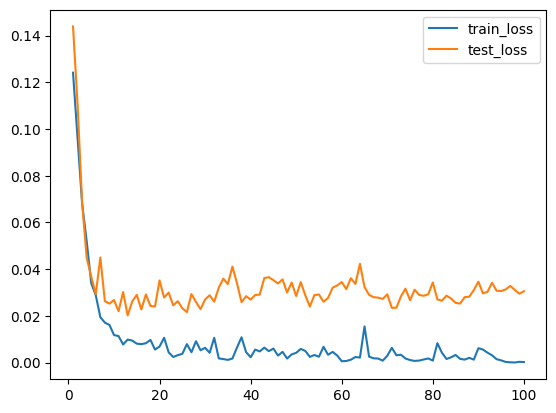

In [19]:
plt.plot(range(1, epoches+1), train_loss, label="train_loss")
plt.plot(range(1, epoches+1), test_loss, label="test_loss")
plt.legend()

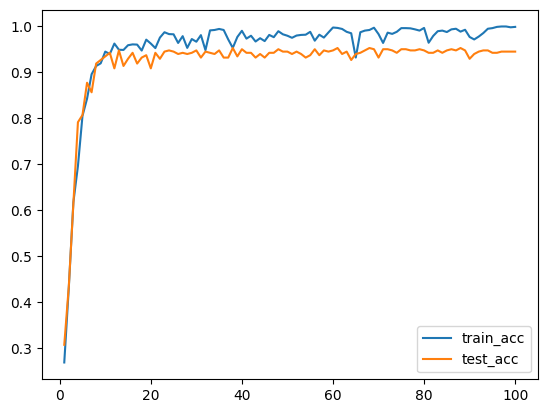

In [20]:
plt.plot(range(1, epoches+1), train_acc, label="train_acc")
plt.plot(range(1, epoches+1), test_acc, label="test_acc")
plt.legend()

# Test

In [21]:
path = os.path.join(result_dir, 'weights.pth')
if path != '':
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model'], strict=False)
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(path), "start", epoch_start)

Loaded from: /home/leo/Classification/04CNN/results/0823-105305-mobilenetv3_large/weights.pth start 101


In [22]:
def test(model, testloader):

    test_correct = 0
    test_total = 0
    test_running_loss = 0
    test_pred_list = []
    test_label_list = []

    # 预测模式影响 dropout Batch, Normalization
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
                
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

            test_label_list.extend(y.cpu().numpy())
            test_pred_list.extend(y_pred.cpu().numpy())

    test_loss = test_running_loss / len(testloader.dataset)
    test_accuracy = test_correct / test_total

    print('test_loss: ', round(test_loss, 3),
        'test_accuracy', round(test_accuracy, 3))

    return test_loss, test_accuracy, test_pred_list, test_label_list

In [23]:
starttime = time.time()
test_loss, test_acc, test_preds, test_labels = test(model, test_dl)
test_time = time.time() - starttime

test_loss:  0.031 test_accuracy 0.945


In [24]:
matrix, classification, accuracy, precision, recall, f1, kappa = \
                            metric_log(test_preds, test_labels)
f = open(os.path.join(result_dir, 'results.txt'), 'a+')
str_results = '\n ======================' \
            + '\n' + classification \
            + "\nmatrix = \t\t" + str(matrix) \
            + "\naccuracy = \t\t" + str(round(accuracy, 4)) \
            + "\nprecision = \t" + str(round(precision, 4)) \
            + "\nrecall = \t\t" + str(round(recall, 4)) \
            + "\nf1 = \t\t\t\t" + str(round(f1, 4)) \
            + "\nkappa = \t\t\t" + str(round(kappa, 4)) \
            + '\ntrain time = \t' + str(round(dtime, 2)) \
            + '\ntest time = \t' + str(round(test_time, 2)) \
            + '\n'
f.write(str_results)
f.close()

accuracy 0.9453125
precision 0.9432475319638041
recall 0.9421693622940673
f1 0.9421844266499306
kappa 0.9383594627855958
